In [6]:
import numpy as np
from sympy import totient
import plotly.offline as pyo
import plotly.graph_objs as go
import sympy as sym
from scipy.stats import qmc  
import plotly.subplots as sp
import matplotlib.pyplot as plt


In [7]:
def graph_two(arr1, arr2, dimensions, names, colors):
    d_1, d_2 = dimensions
    
    fig = sp.make_subplots(rows=1, cols=2, subplot_titles=names)
    
    for i, (arr, name, color) in enumerate(zip([arr1, arr2], names, colors), start=1):
        fig.add_trace(go.Scatter(x=arr[:, d_1 - 1], y=arr[:, d_2 - 1], mode='markers',
                                 marker=dict(size=8, line=dict(color='purple', width=1), color=color),
                                 name=name),
                      row=1, col=i)
        
        fig.update_xaxes(title_text=f'dim = {d_1}', row=1, col=i, title_font=dict(size=14))
        fig.update_yaxes(title_text=f'dim = {d_2}', row=1, col=i, title_font=dict(size=14))
    
    fig.update_layout(
        autosize=False,
        width=900,
        height=450,
        plot_bgcolor='rgba(128, 128, 128, 0.2)',
        paper_bgcolor='white'
    )
    
    fig.show()
    
def graph_one_2D(arr, d_1, d_2, title: str, color: str):

    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=arr[:,d_1-1], y=arr[:,d_2-1], mode='markers', line=dict(color=color)))
    fig.update_layout(
        title=title,
        xaxis_title=f'dim={d_1}',
        yaxis_title=f'dim={d_2}',
        width=500,
        height=500,
        plot_bgcolor='rgba(128, 128, 128, 0.2)' 
    )
    
    fig.show()



def graph_multiple(arr, dimensions_list, names, colors):
    
    num_graphs = len(dimensions_list)
    rows = (num_graphs + 1) // 2  
    cols = 2  

    fig = sp.make_subplots(rows=rows, cols=cols, subplot_titles=names)
    
    for i, ((d_1, d_2), name, color) in enumerate(zip(dimensions_list, names, colors), start=1):
        row = (i + 1) // 2
        col = i % 2 if i % 2 != 0 else 2  

   
        fig.add_trace(go.Scatter(x=arr[:,d_1-1], y=arr[:,d_2-1], mode='markers', 
                                 marker=dict(size=8, line=dict(color='purple', width=1), color=color), 
                                 name=name),
                      row=row, col=col)
       
        fig.update_xaxes(title_text=f'dim = {d_1}', row=row, col=col, title_font=dict(size=14))
        fig.update_yaxes(title_text=f'dim = {d_2}', row=row, col=col, title_font=dict(size=14))
        fig.update_layout(
            autosize=False,
            width=900,
            height=900,
            plot_bgcolor='rgba(128, 128, 128, 0.2)',  
            paper_bgcolor='white'  
        )

    fig.show()

In [8]:
class SobolSequences_G:
    def __init__(self, name: str, dim: int, n0: int, m: int):
        """
        Initializes the QuasiSequences class with the given parameters.

        Args:
            name (str): The name of the sequence ('sobol', 'sobol_farei', etc.)
            dim (int): The dimensionality of the sequence.
            n0 (int): The initial index of the sequence.
            n (int): The number of points to generate.
        """
        self.name = name
        self.n0 = n0
        self.npts = 2**m
        self.dim = dim
        self.b = 2
        self.Y = self.get_Y()
        
    


    def get_seq(self):
        
        if self.name == 'van_der_corput':
            len_seq = int(self.Y .max())
            seq = self.van_der_corput(len_seq)
            return self.seq_pts(seq)
            
        elif self.name == 'farei':
            len_seq = int(self.Y .max())
            seq = self.farei(len_seq)            
            return self.seq_pts(seq)
            
        else:
            raise ValueError(f"Unknown sequence name: {self.name}")

    def seq_pts(self, seq):
        P = np.zeros((self.npts, self.dim))
        for dim_i in range(self.dim):
            # print('--------------------')
            for n_i in range(self.npts):
                y_i = int(self.Y [n_i][dim_i] - 1)
                # print(f'y_i = {y_i}')
                P[n_i][dim_i] = seq[y_i]
        return P
            

    def b_ary(self, k: int) -> np.ndarray:
        """
        Converts an integer k to a base-b representation.

        Args:
            k (int): The integer to convert (k >= 0).

        Returns:
            np.ndarray: A numpy array representing the base-b number.
        """
        if k == 0:
            return np.array([0])

        a = []
        j_max = int(np.log(k) / np.log(self.b))
        a = np.zeros(j_max + 1, dtype=int)
        q = self.b ** j_max
        for j in range(0, j_max + 1):
            a[j] = int(k / q)
            k = k - q * a[j]
            q = q // self.b
        return a

    def nextb_ary(self, a_in: np.ndarray) -> np.ndarray:
        """
        Computes the next number in the base-b representation.

        Args:
            a_in (np.ndarray): Current base-b number.

        Returns:
            np.ndarray: The next base-b number.
        """
        m = len(a_in)
        carry = True
        a_out = np.zeros(m, dtype=int)

        for i in range(m - 1, -1, -1):
            if carry:
                if a_in[i] == self.b - 1:
                    a_out[i] = 0
                else:
                    a_out[i] = a_in[i] + 1
                    carry = False
            else:
                a_out[i] = a_in[i]

        if carry:
            a_out = np.insert(a_out, 0, 1)

        return a_out

    def find_c_vec(self, d: int) -> int:
        """
        Reads a file and finds the s and a values for a given d, then converts them to a number.

        Args:
            d (int): The index of the row in the file.

        Returns:
            int: The converted value based on s and a.
        """
        dir_file = 'C:/Users/Vlada/Desktop/Sirius/NIR/code/data_sobol.21201'
        with open(dir_file, 'r') as infile:
            lines = infile.readlines()
            line = lines[d - 1].split()
            s, a = map(int, line[1:3])
            p = self.num_base_2(s, a)
        return int(p)

    def num_base_2(self, s: int, a: int) -> int:
        """
        Converts the values s and a to a binary number.

        Args:
            s (int): Degree of the polynomial.
            a (int): The integer to convert to binary.

        Returns:
            int: The decimal value of the modified binary representation.
        """
        if s == 0 and a == 0:
            num_a_2 = 1
        else:
            num_a = ''
            while a > 0:
                ost = a % 2
                num_a += str(ost)
                a //= 2

            delta = s - len(str(num_a)) - 1
            num_a = '1' + '0' * delta + num_a[::-1] + '1'
            num_a_2 = self.binary_to_decimal(num_a)
        return num_a_2

    def binary_to_decimal(self, binary_str: str) -> int:
        """
        Converts a binary string to a decimal integer.

        Args:
            binary_str (str): The binary string to convert.

        Returns:
            int: The decimal value of the binary string.
        """
        decimal_num = 0
        power = 0
        for digit in binary_str[::-1]:
            if digit == '1':
                decimal_num += 2 ** power
            power += 1
        return decimal_num

    def read_m(self, d: int) -> list[int]:
        """
        Reads a file and returns the initial m_i values for a given d.

        Args:
            d (int): The index of the row in the file.

        Returns:
            list[int]: A list of integers representing the m_i values.
        """
        if d == 1:
            m = [1]
        else:
            dir_file = 'C:/Users/Vlada/Desktop/Sirius/NIR/code/Sobol/new-joe-kuo-6.21201'
            with open(dir_file, 'r') as infile:
                lines = infile.readlines()
                line = lines[d - 1].split()
                m = list(map(int, line[3:]))
        return m

    def generate_MJ(self, C_vec: list[int], minit: list[int], r: int) -> list[int]:
        """
        Generates a sequence based on the C_vec coefficients and minit initial sequence.

        Args:
            C_vec (list[int]): A list of coefficients for the linear recurrence relation.
            minit (list[int]): The initial sequence.
            r (int): The desired length of the sequence.

        Returns:
            list[int]: The generated sequence.
        """
        q = len(C_vec) - 1
        sequence = minit[:]

        for j in range(len(minit), r):
            mj = 0
            for i in range(q):
                if C_vec[i]:
                    a = ((2 ** (i + 1)) * C_vec[i] * sequence[j - (i + 1)])
                    mj ^= a

            mj ^= (sequence[j - q])
            sequence.append(mj)

        return sequence

    def sobolmat(self, cvec: list[int], minit: list[int], r: int) -> np.ndarray:
        """
        Generates a matrix based on the given coefficients and initial sequence.

        Args:
            cvec (list[int]): The coefficients for the recurrence relation.
            minit (list[int]): The initial sequence.
            r (int): The size of the resulting matrix.

        Returns:
            np.ndarray: The generated matrix.
        """
        q = len(cvec) - 1
        if q == 0:
            V = np.eye(r, dtype=int)
        else:
            mvec = list(minit) + [0] * (r - len(minit))

            for i in range(q, r):
                m_next = 0
                for l in range(q):
                    if cvec[l]:
                        m_next ^= ((2 ** (l + 1)) * cvec[l] * mvec[i - (l + 1)])

                m_next ^= mvec[i - q]
                mvec[i] = m_next

            V = np.zeros((r, r), dtype=int)
            for j in range(r):
                m_bin = self.b_ary(mvec[j])
                k = len(m_bin)
                for i in range(k):
                    V[j - i, j] = m_bin[k - i - 1]

        return V

  

    def sobolpts(self) -> np.ndarray:
        """
        Generates Sobol points based on the provided parameters.

        Args:
            n0 (int): The starting index for Sobol sequence.
            npts (int): The number of points to generate.
            d (int): The dimensionality of the points.
            pvec (list[int]): A list of prime numbers used for generation.
            mmat (np.ndarray): The initialization matrix.

        Returns:
            np.ndarray: The generated Sobol points.
        """
        pvec = [1] + [self.find_c_vec(d) for d in range(2, self.dim + 1)]
        mmat =  [[0]] + [self.read_m(d) for d in range(2, self.dim + 1)]
        
        nmax = self.n0 + self.npts - 1
        rmax = 1 + int(np.log2(nmax))
        P = np.zeros((self.npts, self.dim))
        y = np.zeros(rmax, dtype=int)

        r = (1 + int(np.log2(self.n0 - 1))) if self.n0 > 1 else 1
        a = self.b_ary(self.n0 - 1)
        qnext = 2 ** r

        V_list = []

        for i in range(self.dim):
            q = int(np.log2(pvec[i]))
            cvec = self.b_ary(pvec[i])
            mj = mmat[i][:q]
            V = self.sobolmat(cvec, mj, rmax)
            V_list.append(V)

        bpwrs = np.array([1 / (2 ** i) for i in range(1, rmax + 1)])

        for k in range(self.npts):
            a = self.nextb_ary(a)
            if k + self.n0 == qnext:
                r += 1
                qnext *= 2

            for j in range(r):
                P[k, 0] += bpwrs[j] * a[r - j - 1]

            for i in range(1, self.dim):
                V = V_list[i]
                for m in range(r):
                    for n in range(r):
                        y[m] += V[m, n] * a[r - n - 1]
                    # print(f'y={y}') # сохранить y, (умножаем на 2**m)
                    y[m] %= 2
                    P[k, i] += bpwrs[m] * y[m]
                    y[m] = 0
                # print('------------------------------')

        return P


    def farei(self, len_seq):
        # Находим минимальное n_farey, чтобы получить хотя бы len_seq элементов
        n_farey = self.find_n_for_farey_length_binary(len_seq)
        
        result = []
        
        def farey_sequence_rec(x, y, z, t):
            a, b = x + z, y + t
            if b <= n_farey:
                farey_sequence_rec(x, y, a, b)
                if a != 0:
                    result.append(a / b)
                farey_sequence_rec(a, b, z, t)
        
       
        farey_sequence_rec(0, 1, 1, 1)  # генерируем последовательность Фарея
        result.append(1.0)  # завершающее значение 1.0
        
        # выбираем ровно len_seq элементов, равномерно распределённых
        if len(result) > len_seq:
            step = len(result) / len_seq
            result = [result[int(i * step)] for i in range(len_seq)]
        
        return result
        
    def find_n_for_farey_length_binary(self, m):
        def farey_length(n):
            return  sum(totient(q) for q in range(1, n + 1))

        low, high = 1, m+1
        while low < high:
            mid = (low + high) // 2
            if farey_length(mid) < m:
                low = mid + 1
            else:
                high = mid

        return low




    def get_Y(self) -> np.ndarray:

        pvec = [1] + [self.find_c_vec(d) for d in range(2, self.dim + 1)]
        mmat =  [[0]] + [self.read_m(d) for d in range(2, self.dim + 1)]
        
        nmax = self.n0 + self.npts - 1
        rmax = 1 + int(np.log2(nmax))
        Y_list = np.zeros((self.npts, self.dim))
        y = np.zeros(rmax, dtype=int)

        r = (1 + int(np.log2(self.n0 - 1))) if self.n0 > 1 else 1
        a = self.b_ary(self.n0 - 1)
        qnext = 2 ** r

        V_list = []

        for i in range(self.dim):
            q = int(np.log2(pvec[i]))
            cvec = self.b_ary(pvec[i])
            mj = mmat[i][:q]
            V = self.sobolmat(cvec, mj, rmax)
            V_list.append(V)

        bpwrs = np.array([(2 ** i) for i in range(0, rmax)])

        for k in range(self.npts):
            a = self.nextb_ary(a)
            if k + self.n0 == qnext:
                r += 1
                qnext *= 2

            for j in range(r):
                Y_list[k, 0] += bpwrs[j] * a[r - j - 1]

            for i in range(1, self.dim):
                V = V_list[i]
                for m in range(r):
                    for n in range(r):
                        y[m] += V[m, n] * a[r - n - 1]
                    y[m] %= 2
                    Y_list[k, i] += bpwrs[m] * y[m]
                    y[m] = 0

        return Y_list
  
    
    def van_der_corput(self, len_seq):
        A = np.zeros(len_seq)
        
        for k in range(len_seq):
            a = self.b_ary(self.n0 + k)
            A[k] = np.dot(a[::-1], 1 / (self.b ** np.arange(1, len(a) + 1)))
        
        return A
    
    
      
    
  








### Проверка нового способа 

In [ ]:
name = 'van_der_corput'

dim = 5
n0 = 1
m = 3
seq = SobolSequences_G (name, dim, n0, m)

p1 = seq.get_seq()
p2 = seq.sobolpts()
(p1-p2).max()

0.0

In [ ]:
print(f'sobolpts   {qmc.discrepancy(p2)}')
print(f'NEW        {qmc.discrepancy(p1)}')

sobolpts   0.08170956386445472
NEW        0.08170956386445472


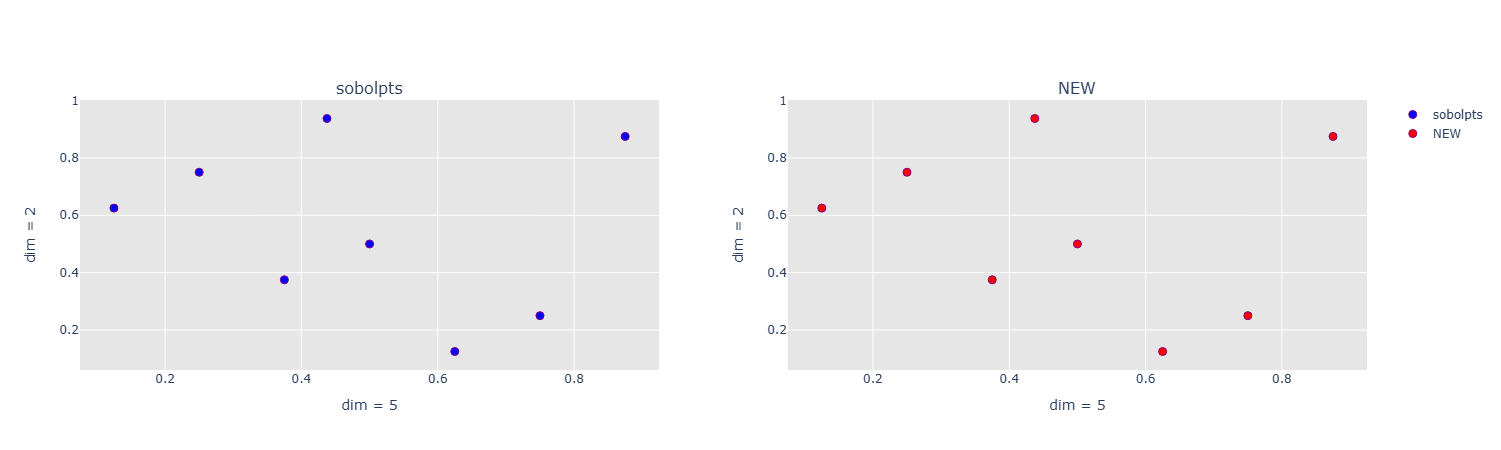

In [ ]:
graph_two(p1, p2, (5, 2), ['sobolpts', 'NEW'], ['blue', 'red'])

---

In [ ]:
seq.get_Y()

array([[ 1.,  1.,  1.,  1.,  1.],
       [ 2.,  3.,  3.,  3.,  2.],
       [ 3.,  2.,  2.,  2.,  3.],
       [ 4.,  5.,  6.,  4.,  4.],
       [ 5.,  4.,  7.,  5.,  5.],
       [ 6.,  6.,  5.,  7.,  6.],
       [ 7.,  7.,  4.,  6.,  7.],
       [ 8., 15.,  9., 13., 14.]])